In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflowjs as tfjs
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_loc = 'data/train_data'
test_loc = 'data/test_data'
real_folder = "data/train_data/real"
fake_folder = "data/train_data/fake"

In [2]:
real_path = os.listdir(real_folder)
fake_path = os.listdir(fake_folder)

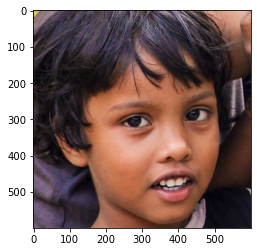

In [3]:
i = 0
img = mpimg.imread(real_folder + '/' + real_path[i])
imgplot = plt.imshow(img)
plt.show()

In [4]:
i=0
im = cv2.imread(real_folder + '/' + real_path[i])

print(type(im))
print(im.shape)
print(type(im.shape))

<class 'numpy.ndarray'>
(600, 600, 3)
<class 'tuple'>


In [5]:
im[2]

array([[ 62, 157, 172],
       [ 67, 162, 177],
       [ 74, 171, 185],
       ...,
       [132, 146, 205],
       [127, 143, 202],
       [131, 147, 206]], dtype=uint8)

### Load Data from disk

In [6]:
# Define parameters for loading
batch_size = 32
img_height = 256
img_width = 256

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_loc,
    labels="inferred",
    label_mode="int",
    class_names=['fake', 'real'],
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_loc,
    labels="inferred",
    label_mode="int",
    class_names=['fake', 'real'],
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    follow_links=False,
)

Found 2032 files belonging to 2 classes.
Using 1626 files for training.
Found 2032 files belonging to 2 classes.
Using 406 files for validation.


In [8]:
class_names=train_ds.class_names
print(class_names)

['fake', 'real']


In [9]:
for images, labels in train_ds.take(1):
    print(labels)

tf.Tensor([1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 0 0], shape=(32,), dtype=int32)


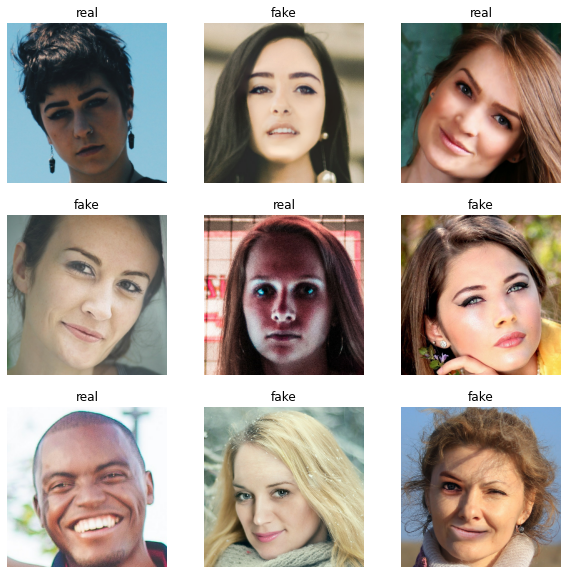

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, label_batch in train_ds:
    print(image_batch.numpy().shape)
    print(label_batch.numpy().shape)
    break
    
# The image_batch is a tensor of the shape (32, 256, 256, 3). This is a batch of 32 images of shape
# 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape
# (32,), these are corresponding labels to the 32 images.

(32, 256, 256, 3)
(32,)


### Configure ds for performance

In [12]:
# configure ds for performance
# Cache keeps images in memory after they're loaded on first epoch
# prefetch overlaps data preprocessing and model execution while trianing

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data

In [13]:
# Normalize rbg channels from [0,255] to [0,1] for nn
# The rescaling is applied both during training and inference.

normalize_layer = layers.experimental.preprocessing.Rescaling(1./255)
# Will be apploed in the nn instead of before 

### Create the model

In [33]:
# conv2d()   2D convolution layer (e.g. spatial convolution over images).
# MaxPooling2D()   Downsamples the input representation by taking the maximum value over the window defined by pool_size for each dimension along the features axis.
# Flatten()  Flattens the input. Does not affect the batch size.  (converts to 1D)
# Dense   regular densely-connected NN layer. 
#            output = activation(dot(input, kernel) + bias)
#            deeply connected layer


num_classes = 2

model_old = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

### Compile the model

In [34]:
# losses.SparseCategoricalCrossentropy  -  Computes the crossentropy loss between the labels and predictions.
#         CrossEntropy = −(ylog(p)+(1−y)log(1−p))
#         If M>2 (i.e. multiclass classification), we calculate a separate loss for each class label per observation and sum the result.


model_old.compile(optimizer='adam', 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])


In [35]:
model_old.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)       

### Train the model

In [36]:
epochs = 10

history = model_old.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/10
51/51 [==============================] - 33s 639ms/step - loss: 1.5862 - accuracy: 0.5381 - val_loss: 0.6922 - val_accuracy: 0.5560
Epoch 2/10
51/51 [==============================] - 32s 637ms/step - loss: 0.6901 - accuracy: 0.5406 - val_loss: 0.6745 - val_accuracy: 0.6064
Epoch 3/10
51/51 [==============================] - 32s 625ms/step - loss: 0.6671 - accuracy: 0.6025 - val_loss: 0.6352 - val_accuracy: 0.6433
Epoch 4/10
51/51 [==============================] - 32s 627ms/step - loss: 0.6312 - accuracy: 0.6446 - val_loss: 0.5723 - val_accuracy: 0.7183
Epoch 5/10
51/51 [==============================] - 33s 658ms/step - loss: 0.5770 - accuracy: 0.7004 - val_loss: 0.5552 - val_accuracy: 0.6876
Epoch 6/10
51/51 [==============================] - 33s 641ms/step - loss: 0.5225 - accuracy: 0.7226 - val_loss: 0.4094 - val_accuracy: 0.8118
Epoch 7/10
51/51 [==============================] - 33s 652ms/step - loss: 0.3901 - accuracy: 0.8351 - val_loss: 0.3536 - val_accuracy: 0.8389

### Visualizing training results

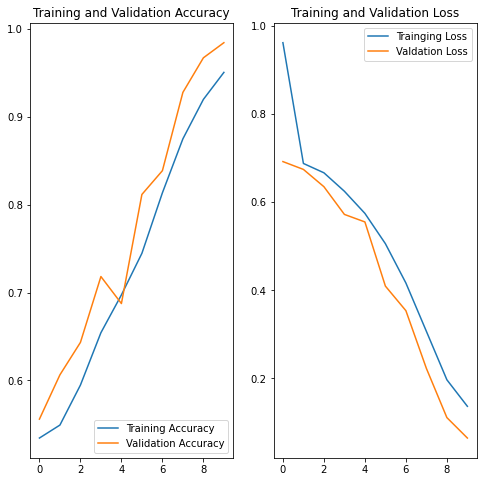

In [37]:
# Create plots of loss and accuracy on the training and validation sets.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Trainging Loss')
plt.plot(epochs_range, val_loss, label='Valdation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


Accuracy plot - training accuracy linearly increading while validation is constant ~ 6. 
         data is overfitting
         

In [18]:
# data Augmentation
# Create new data points with each epoch using random flips, rotaion, and zoom 
# Dropout - force model to create new connections

data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1, input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

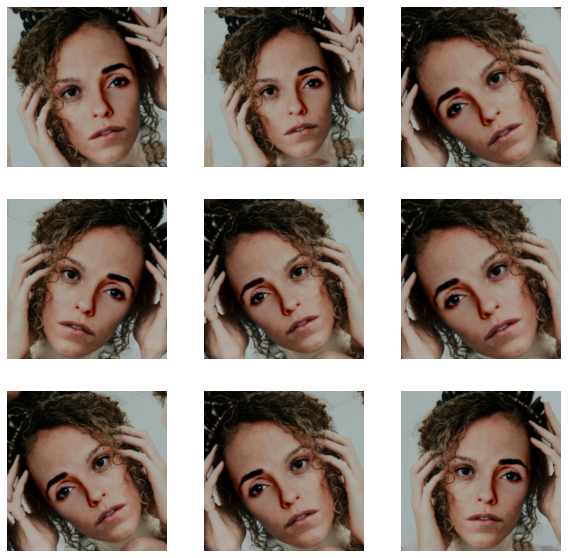

In [19]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images= data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

### Compile and trian new model

In [20]:
num_classes = 2

model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [21]:
model.compile(optimizer=('adam'), 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)       

In [23]:
# train model

epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/15
51/51 [==============================] - 41s 793ms/step - loss: 1.6649 - accuracy: 0.5110 - val_loss: 0.6902 - val_accuracy: 0.5338
Epoch 2/15
51/51 [==============================] - 42s 832ms/step - loss: 0.6904 - accuracy: 0.5443 - val_loss: 0.6885 - val_accuracy: 0.5597
Epoch 3/15
51/51 [==============================] - 40s 786ms/step - loss: 0.6867 - accuracy: 0.5664 - val_loss: 0.6825 - val_accuracy: 0.5394
Epoch 4/15
51/51 [==============================] - 46s 908ms/step - loss: 0.6758 - accuracy: 0.5677 - val_loss: 0.6865 - val_accuracy: 0.5584
Epoch 5/15
51/51 [==============================] - 39s 771ms/step - loss: 0.6821 - accuracy: 0.5524 - val_loss: 0.6772 - val_accuracy: 0.5683
Epoch 6/15
51/51 [==============================] - 41s 803ms/step - loss: 0.6729 - accuracy: 0.5901 - val_loss: 0.6652 - val_accuracy: 0.5929
Epoch 7/15
51/51 [==============================] - 40s 780ms/step - loss: 0.6768 - accuracy: 0.5705 - val_loss: 0.6767 - val_accuracy: 0.5818

Text(0.5, 1.0, 'Training and Validation Loss')

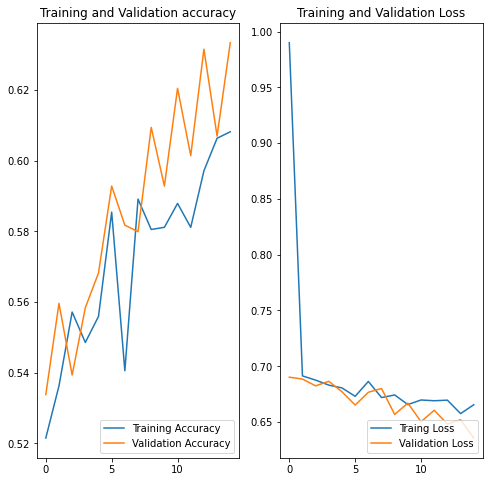

In [24]:
# Visualize training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')


plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Traing Loss")
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [38]:
tfjs.converters.save_keras_model(model, 'model_tf/')
tfjs.converters.save_keras_model(model_old, 'model_old_tf/')
#model.save('model_tf/model.h5')

## Predict on New data

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_loc,
    labels="inferred",
    label_mode="int",
    class_names=['fake', 'real'],
    color_mode="rgb",
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    interpolation="bilinear",
    follow_links=False,
)

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Make predictions on new data. 
    
predictions = model.predict(test_ds)
score = tf.nn.softmax(predictions[0])

#print(
#    "This image most likely belongs to {} with a {:.2f} percent confidence."
#    .format(class_names[np.argmax(score)], 100 * np.max(score))
#    )
#print(predictions)
#print(predictions[0])
    
for images, labels in test_ds.take(1):
    for i in range(8):
        score = tf.nn.softmax(predictions[i])
        print(class_names[labels[i]], predictions[i])
        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(class_names[np.argmax(score)], 100 * np.max(score))
        )
        print('\n')